In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange
import time
import copy
sys.path.append("../../")

# print("Current working directory:", os.getcwd())

from biked_commons.design_evaluation.design_evaluation import *
from biked_commons.resource_utils import split_datasets_path
from biked_commons.design_evaluation.scoring import *

# os.chdir("src")
# print("Current working directory:", os.getcwd())

import argparse
import torch
import numpy as np
from matplotlib import pyplot as plt
from importlib import invalidate_caches
invalidate_caches()

from biked_commons.benchmark_models.libmoon.solver.gradient import MGDASolver, GradAggSolver, EPOSolver, MOOSVGDSolver, GradHVSolver, PMTLSolver
from biked_commons.benchmark_models.libmoon.util_global.constant import problem_dict
from biked_commons.benchmark_models.libmoon.util_global.weight_factor.funs import uniform_pref
from biked_commons.benchmark_models.libmoon.visulization.view_res import vedio_res
from biked_commons.benchmark_models.libmoon.problem.mop import mop
from biked_commons.benchmark_models import benchmarking_utils

import sys
print(sys.version)

c:\Users\Lyler\mambaforge\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]


In [2]:
data = pd.read_csv(split_datasets_path("bike_bench.csv"), index_col=0)

In [3]:
device = torch.device("cpu")
# "cuda" if torch.cuda.is_available() else

In [4]:
class MOOProblem(mop):
    def __init__(self, data_sample_df, condition=None, device=None):
        self.evaluator, self.requirement_names, requirement_types = construct_tensor_evaluator(
            get_standard_evaluations(device), data.columns, device=device
        )

        self.isobjective = torch.tensor(requirement_types) == 1
        self.objective_names = np.array(self.requirement_names)[self.isobjective.numpy()]
        self.ref_point = get_ref_point(self.evaluator, self.objective_names, self.isobjective)

        data_sample = data_sample_df.to_numpy()
        n_var = data_sample.shape[1]
        lbound = np.min(data_sample, axis=0)
        ubound = np.max(data_sample, axis=0)

        super().__init__(
            n_var=n_var,
            n_obj=self.isobjective.sum().item(),
            lbound=lbound,
            ubound=ubound
        )

        self.problem_name = 'MOO'
        self.condition = condition

    def eval_fn(self, x, condition):
        score = self.evaluator(x, condition)
        objective_scores = score[:, self.isobjective]
        constraint_scores = score[:, ~self.isobjective]
        constraint_violations = torch.clamp(constraint_scores, min=0.0)
        penalty = constraint_violations.sum(dim=1, keepdim=True)
        penalized_objectives = objective_scores + 1e3 * penalty
        return penalized_objectives

    def _evaluate_torch(self, x):
        return self.eval_fn(x, self.condition)

In [5]:
def test(problem, args, x0, prefs, solver):
    print("=" * 50)
    print(f"Running test with solver: {solver.__class__.__name__}")
    start_time = time.time()
    
    res = solver.solve(
        problem,
        x=x0,
        prefs=prefs,
        args=args,
        ref_point=problem.ref_point
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time completed: {elapsed_time:.2f} seconds")

    x0_np = x0.cpu().numpy() if isinstance(x0, torch.Tensor) else x0
    res_x_np = res['x'].cpu().numpy() if isinstance(res['x'], torch.Tensor) else res['x']

    assert x0_np.shape == res_x_np.shape, "Shape mismatch between x0 and result"

    num_affected = sum(
        np.count_nonzero(res_x_np[i] != x0_np[i])
        for i in range(x0_np.shape[0])
    )
    avg_affected = num_affected / x0.shape[0]
    print(f"Average Number of Parameters Affected: {avg_affected:.2f}")
    print("=" * 50)
    return res

In [7]:
def run_solver(cond_idx, solver_name="agg", device=device):
    condition = benchmarking_utils.get_condition_by_idx(cond_idx)
    parser = argparse.ArgumentParser(description='example')
    parser.add_argument('--n-partition', type=int, default=10)
    parser.add_argument('--agg', type=str, default='tche')
    parser.add_argument('--solver', type=str, default='agg')
    parser.add_argument('--iter', type=int, default=1000)
    parser.add_argument('--step-size', type=float, default=1e-2)
    parser.add_argument('--tol', type=float, default=1e-6)

    args = parser.parse_args(args=[
        '--n-partition', '2',
        '--agg', 'tche',
        '--solver', 'agg',
        '--iter', '10',
        # '--step-size', '0.1',
        '--tol', '1e-6'
    ])
    args.n_var = data.shape[1]

    problem = MOOProblem(data_sample_df=data, condition=condition, device=device)

    args.n_obj = problem.n_obj
    # prefs = uniform_pref(args.n_partition, args.n_obj, clip_eps=1e-2)
    prefs = torch.tensor(
        uniform_pref(args.n_partition, args.n_obj, clip_eps=1e-2),
        dtype=torch.float32,
        device=device 
    )
    args.n_prob = len(prefs)

    # x0 = torch.tensor(data.iloc[0].to_numpy(), dtype=torch.float32).repeat(args.n_prob, 1)
    x0 = torch.tensor(
        data.sample(n=args.n_prob, replace=True).to_numpy(), 
        dtype=torch.float32,
        device=device
    )
    # Logging setup info
    print(f"Number of Objectives: {args.n_obj}")
    print(f"Number of Preferences: {args.n_prob}")
    print(f"Number of Constraints: {(~problem.isobjective).sum().item()}")
    print(f"x0 shape: {x0.shape}")
    # print(f"Condition: {condition}")
    print(f"Requirement Names: {problem.requirement_names}")
    print(f"Ref Point: {problem.ref_point}")

    print(f"Testing solver: {solver_name}")
    
    if solver_name == 'mgda':
        args.step_size = 0.1
        num_trials = 1
        solver = MGDASolver(args.step_size, args.iter, args.tol)  # Small grads breaks it
    elif solver_name == 'Agg-LS':
        args.step_size = 0.1
        args.iter = 1000
        num_trials = 1
        solver = GradAggSolver(args.step_size, args.iter, args.tol, device)  # Works well
    elif solver_name == 'EPO':
        args.step_size = 0.1
        num_trials = 1
        solver = EPOSolver(args.step_size, args.iter, args.tol) # Sensitive to NaN values (aero breaks it)
    else:
        raise ValueError(f"Solver '{solver_name}' not supported.")
    
    all_results = []
    for i in range(num_trials):
        res = test(
            problem,
            copy.deepcopy(args),
            x0.clone(),
            prefs.clone(),
            solver
        )
        all_results.append(torch.tensor(res['x'], dtype=torch.float32, device=device))
    all_results = torch.concat(all_results, dim=0)
    benchmarking_utils.evaluate_uncond(all_results, solver_name, cond_idx, data.columns, device)
    return problem, res

# for i in range(10):
#     for solver in ['Agg-LS', 'EPO']:
#         problem, res = run_solver(cond_idx=i, solver_name=solver, device = device)
i = 0
solver = 'Agg-LS'
problem, res = run_solver(cond_idx=i, solver_name=solver, device = device)

Number of Objectives: 10
Number of Preferences: 55
Number of Constraints: 15
x0 shape: torch.Size([55, 94])
Requirement Names: ['Usability Score - 0 to 1', 'Drag Force', 'Knee Angle Error', 'Hip Angle Error', 'Arm Angle Error', 'Cosine Distance to Embedding', 'Mass', 'Planar Compliance', 'Transverse Compliance', 'Eccentric Compliance', 'Planar Safety Factor', 'Eccentric Safety Factor', 'Saddle height too small', 'Seat post too short', 'Head tube lower extension too great', 'Head tube length too great', 'Certain parameters must be positive', 'Chain stay should be greater than wheel radius', 'Chain stay should be greater than BB', 'Seat stay should be greater than wheel radius', 'Down tube must reach head tube', "The pedal shouldn't intersect the front wheel", "The crank shouldn't hit the ground when it is in its lower position", 'RGB value should be less than 255', 'Predicted Frame Validity']
Ref Point: [1.0000000e+00 2.9636734e+01 1.9729372e+02 8.0775903e+02 8.4349000e+02
 5.4179370e-0

100%|██████████| 1000/1000 [03:23<00:00,  4.93it/s]


Time completed: 203.02 seconds
Average Number of Parameters Affected: 78.38


In [ ]:
for i in range(10):
    os.makedirs(f"results/unconditional/cond_{i}", exist_ok=True)

In [ ]:
# res_arr = []
# for solver_name in ['agg','epo']:
#     print(f"Testing solver: {solver_name}")
    
#     if solver_name == 'mgda':
#         args.step_size = 0.1
#         args.iter = 10
#         solver = MGDASolver(args.step_size, args.iter, args.tol)  # Small grads breaks it
#     elif solver_name == 'agg':
#         args.iter = 100
#         args.step_size = 0.01
#         solver = GradAggSolver(args.step_size, args.iter, args.tol, device)  # Works well
#     elif solver_name == 'epo':
#         args.step_size = 0.01
#         args.iter = 10
#         solver = EPOSolver(args.step_size, args.iter, args.tol) # Sensitive to NaN values (aero breaks it)
#     else:
#         raise ValueError(f"Solver '{solver_name}' not supported.")
    
#     res_arr.append(test(
#         problem,
#         copy.deepcopy(args),
#         x0.clone(),
#         prefs.clone(),
#         solver
#     ))

In [ ]:
# result_tens = torch.tensor(res_arr[0]['x'], dtype=torch.float32, device=device)
# main_scorer = construct_scorer(MainScores, StandardEvaluations, data.columns)
# detailed_scorer = construct_scorer(DetailedScores, StandardEvaluations, data.columns)
# print('agg solver')
# print(main_scorer(result_tens, condition))

# result_tens = torch.tensor(res_arr[1]['x'], dtype=torch.float32, device=device)
# main_scorer = construct_scorer(MainScores, StandardEvaluations, data.columns)
# detailed_scorer = construct_scorer(DetailedScores, StandardEvaluations, data.columns)
# print('\nepo solver')
# print(main_scorer(result_tens, condition))


# Ignore

In [ ]:
def test_all(args, condition, x0, prefs):
    print("Testing solely aero")
    evaluator, requirement_names, requirement_types = construct_tensor_evaluator(StandardEvaluations, data.columns)
    isobjective = torch.tensor(requirement_types) == 1
    objective_names = requirement_names[isobjective]
    ref_point = get_ref_point(evaluator, objective_names, isobjective)

    def eval_fn(x, condition): # All scores should be minimised
        return evaluator(x, condition)


    solver = GradAggSolver(args.step_size, args.iter, args.tol)
    problem = bicycle(condition=condition, eval_fn=eval_fn)

    res = solver.solve(problem, x=x0, prefs=prefs, args=args, ref_point=ref_point)

    ####### Checking improvements #######

    diff = res['x'][0] - x0.numpy()
    print('Number of parameters affacted', np.count_nonzero(diff))
    initial = evaluator(x0, condition)
    final = evaluator(torch.tensor(res['x']), condition) 

    print('Score initial: ', initial)
    print('Score final: ', final)

    if initial > final:
        print("Score improved")
    else:
        print("Score not improved")

In [ ]:
num_data = 1
rider_condition = conditioning.sample_riders(num_data, split="test")
use_case_condition = conditioning.sample_use_case(num_data, split="test")
text_condition = conditioning.sample_text(num_data, split="test")

parser = argparse.ArgumentParser(description='example')
parser.add_argument('--n-partition', type=int, default=10)
parser.add_argument('--agg', type=str, default='tche')
parser.add_argument('--solver', type=str, default='agg')
parser.add_argument('--problem-name', type=str, default='VLMOP2')
parser.add_argument('--iter', type=int, default=1000)
parser.add_argument('--step-size', type=float, default=1e-2)
parser.add_argument('--tol', type=float, default=1e-6)

args = parser.parse_args(args=[
    '--n-partition', '10',
    '--agg', 'tche',
    '--solver', 'agg',
    '--iter', '1000',
    '--step-size', '0.01',
    '--tol', '1e-6'
])
args.n_var = data.shape[1]

num_objectives = 2
args.n_obj = num_objectives
prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Two Objective
args.n_prob = len(prefs)

prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Two Objective

x0 = torch.rand(args.n_prob, data.shape[1])

solver = GradAggSolver(args.step_size, args.iter, args.tol)

res = test_all(args, condition, x0, prefs, solver)

NameError: name 'condition' is not defined

In [ ]:
from numpy import array


def test_solely_usability(args, condition, x0, prefs):
    print("Testing solely usability")
    usableEV = [
        UsabilityEvaluator(),
    ]
    evaluator_usable, _, _ = construct_tensor_evaluator(usableEV, data.columns)

    def eval_fn(x, condition): # All scores should be minimised
        return 1- evaluator_usable(x, condition)

    solver = GradAggSolver(args.step_size, args.iter, args.tol)
    problem = bicycle(condition=condition, eval_fn=eval_fn)

    res = solver.solve(problem, x=x0, prefs=prefs, args=args, ref_point=array([ 1.0 ]))

    ####### Checking improvements #######

    # Should only have affacted 3 parameters
    diff = res['x'][0] - x0.numpy()
    print('Number of parameters affacted', np.count_nonzero(diff))
    initial_usability = evaluator_usable(x0, condition)
    final_usability = evaluator_usable(torch.tensor(res['x']), condition)  

    print('Usability score initial: ', initial_usability)
    print('Usability score final: ', final_usability)

    if initial_usability < final_usability:
        print("Usability score improved")
    else:
        print("Usability score not improved")


def test_solely_aero(args, condition, x0, prefs):
    print("Testing solely aero")
    aeroEV = [
        AeroEvaluator(),
    ]
    evaluator, _, _ = construct_tensor_evaluator(aeroEV, data.columns)

    def eval_fn(x, condition): # All scores should be minimised
        return evaluator(x, condition)


    solver = GradAggSolver(args.step_size, args.iter, args.tol)
    problem = bicycle(condition=condition, eval_fn=eval_fn)


    res = solver.solve(problem, x=x0, prefs=prefs, args=args, ref_point=array([ 25.0 ]))

    ####### Checking improvements #######

    diff = res['x'][0] - x0.numpy()
    print('Number of parameters affacted', np.count_nonzero(diff))
    initial = evaluator(x0, condition)
    final = evaluator(torch.tensor(res['x']), condition) 

    print('Score initial: ', initial)
    print('Score final: ', final)

    if initial > final:
        print("Score improved")
    else:
        print("Score not improved")


def test_usability_aero(args, condition, x0, prefs, solver):

    print("Testing combined usability and aero")
    aeroEV = [
        AeroEvaluator(),
    ]
    usableEV = [
        UsabilityEvaluator(),
    ]
    evaluator_aero, _, _ = construct_tensor_evaluator(aeroEV, data.columns)
    evaluator_usable, _, _ = construct_tensor_evaluator(usableEV, data.columns)

    def eval_fn(x, condition): # All scores should be minimised
        usable_score = 1 - evaluator_usable(x, condition)
        aero_score = evaluator_aero(x, condition)
        comb = torch.cat((usable_score, aero_score), dim=1)
        return comb


    problem = bicycle(condition=condition, n_obj=2, eval_fn=eval_fn)

    start_time = time.time()
    res = solver.solve(problem, x=x0, prefs=prefs, args=args, ref_point=array([1.0 , 25.0 ]))  # ref_point used for HV
    end_time = time.time()
    print(f"Time completed: {end_time - start_time:.2f} seconds")

    ####### Checking improvements #######
    x0_np = x0.numpy() if isinstance(x0, torch.Tensor) else x0
    res_x_np = res['x'].numpy() if isinstance(res['x'], torch.Tensor) else res['x']

    assert x0_np.shape == res_x_np.shape, "The shapes of x0 and res['x'] must match"

    num_affected = 0
    for i in range(x0_np.shape[0]):  # Iterate over rows
        diff = np.count_nonzero(res_x_np[i] != x0_np[i])  
        num_affected += diff  

    print('Average Number of parameters affected:', num_affected/x0.shape[0])

    condition_test = {
        "Rider": condition["Rider"][0:1],
        "Use Case": condition["Use Case"][0:1], 
        "Text": condition["Text"][0:1]
    }   

    aero_improved = 0
    usability_improved = 0

    aero_valid_counter = 0
    usability_valid_counter = 0
    for x0_row, res_row in zip(x0, res['x']):
        initial_aero = evaluator_aero(x0_row.unsqueeze(0), condition_test)
        final_aero = evaluator_aero(torch.tensor(res_row).unsqueeze(0), condition_test)  
        initial_usability = evaluator_usable(x0_row.unsqueeze(0), condition_test)
        final_usability = evaluator_usable(torch.tensor(res_row).unsqueeze(0), condition_test)  

        if not torch.isnan(initial_aero).any():
            aero_valid_counter += 1
            if initial_aero > final_aero :
                aero_improved += 1

        if not torch.isnan(initial_usability).any():
            usability_valid_counter += 1    
            if initial_usability < final_usability :
                usability_improved += 1

    if aero_valid_counter == 0:
        print("No valid aero scores found")
    else:
        print('Aero score improved: ', aero_improved/aero_valid_counter)

    if usability_valid_counter == 0:
        print("No valid usability scores found")
    else:
        print('Usability score improved: ', usability_improved/usability_valid_counter)
    return res

In [ ]:
parser = argparse.ArgumentParser(description='example')
parser.add_argument('--n-partition', type=int, default=10)
parser.add_argument('--agg', type=str, default='tche')
parser.add_argument('--solver', type=str, default='agg')
parser.add_argument('--problem-name', type=str, default='VLMOP2')
parser.add_argument('--iter', type=int, default=1000)
parser.add_argument('--step-size', type=float, default=1e-2)
parser.add_argument('--tol', type=float, default=1e-6)

args = parser.parse_args(args=[
    '--n-partition', '10',
    '--agg', 'tche',
    '--solver', 'agg',
    '--iter', '1000',
    '--step-size', '0.01',
    '--tol', '1e-6'
])
args.n_var = data.shape[1]


num_data = 1
rider_condition = conditioning.sample_riders(num_data, split="test")
use_case_condition = conditioning.sample_use_case(num_data, split="test")
text_condition = conditioning.sample_text(num_data, split="test")

############### Single Objective #######################

num_objectives = 1
prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Single Objective
args.n_prob = len(prefs)
condition = {
    "Rider": torch.cat([rider_condition] * prefs.shape[0], dim=0),
    "Use Case": torch.cat([use_case_condition] * prefs.shape[0], dim=0),
    "Text": text_condition * prefs.shape[0]
}

# # Initialize the initial solution 
x0 = torch.rand(args.n_prob, data.shape[1])

test_solely_usability(args, condition, x0, prefs)

test_solely_aero(args, condition, x0, prefs)

############### Multi Objective #######################

num_objectives = 2
args.n_obj = num_objectives
prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Two Objective
args.n_prob = len(prefs)
condition = {
    "Rider": torch.cat([rider_condition] * prefs.shape[0], dim=0),
    "Use Case": torch.cat([use_case_condition] * prefs.shape[0], dim=0),
    "Text": text_condition * prefs.shape[0]
}
prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Two Objective

x0 = torch.rand(args.n_prob, data.shape[1])

solver = GradAggSolver(args.step_size, args.iter, args.tol)

res = test_usability_aero(args, condition, x0, prefs, solver)



Testing solely usability


TypeError: bicycle.__init__() got an unexpected keyword argument 'condition'

In [ ]:
parser = argparse.ArgumentParser(description='example')
parser.add_argument('--n-partition', type=int, default=10)
parser.add_argument('--agg', type=str, default='tche')
parser.add_argument('--iter', type=int, default=2000)
parser.add_argument('--step-size', type=float, default=0.1)
parser.add_argument('--tol', type=float, default=1e-6)
parser.add_argument('--plt-pref-flag', type=str, default='N')

args = parser.parse_args(args=[
    '--n-partition', '100',
    '--agg', 'ls',            # Only usded for the 'agg' solver  'cosmos', 'pbi' , 'tche','mtche','ls'
    '--iter', '1000',
    '--step-size', '0.01',
    '--tol', '1e-6'
])
args.n_var = data.shape[1]

num_data = 1
rider_condition = conditioning.sample_riders(num_data, split="test")
use_case_condition = conditioning.sample_use_case(num_data, split="test")
text_condition = conditioning.sample_text(num_data, split="test")

################ Multiple Solver Tests #######################
solver_list = [ 'agg',  ]
# 'mgda', 'agg', 'epo', 'moosvgd','hvgrad', 'pmtl'
# 

num_objectives = 2
args.n_obj = num_objectives
prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Two Objective
args.n_prob = len(prefs)
condition = {
    "Rider": torch.cat([rider_condition] * prefs.shape[0], dim=0),
    "Use Case": torch.cat([use_case_condition] * prefs.shape[0], dim=0),
    "Text": text_condition * prefs.shape[0]
}
prefs = uniform_pref(args.n_partition, num_objectives, clip_eps=1e-2)  # Two Objective


aeroEV = [
    AeroEvaluator(),
]
condition_test = {
    "Rider": condition["Rider"][0:1],
    "Use Case": condition["Use Case"][0:1], 
    "Text": condition["Text"][0:1]
}   
evaluator_aero, _, _ = construct_tensor_evaluator(aeroEV, data.columns)
x0_list = []  # Store valid rows

while len(x0_list) < args.n_prob:               # Generate new random until we have enough valid rows                
    candidate_row = torch.rand(1, data.shape[1])  
    aero_score = evaluator_aero(candidate_row, condition_test)
    if not torch.isnan(aero_score).any():
        x0_list.append(candidate_row)
x0 = torch.cat(x0_list, dim=0)  


# while True:                                         # Generates duplicate rows                   
#     candidate_row = torch.rand(1, data.shape[1])
#     aero_score = evaluator_aero(candidate_row, condition_test)
#     if not torch.isnan(aero_score).any():
#         break  # Found a valid one
# x0_list = [candidate_row.clone() for _ in range(args.n_prob)]


x0 = torch.cat(x0_list, dim=0)  

res = None
for solver_name in solver_list:
    print(f"Testing solver: {solver_name}")
    if solver_name == 'mgda':                                          
        solver = MGDASolver(args.step_size, args.iter, args.tol)
    elif solver_name == 'agg':                                          
        solver = GradAggSolver(args.step_size, args.iter, args.tol)
    elif solver_name == 'epo':
        solver = EPOSolver(args.step_size, args.iter, args.tol)        # Sensitive to NaN values (aero breaks it)
    elif solver_name == 'moosvgd':
        solver = MOOSVGDSolver(args.step_size, args.iter, args.tol)    # apparently unstable according to authors   
    elif solver_name == 'hvgrad':
        solver = GradHVSolver(args.step_size, args.iter, args.tol)    # Only supports 2 objectives
    elif solver_name == 'pmtl':
        solver = PMTLSolver(args.step_size, args.iter, args.tol)     # Only supports 2 objectives  (not working)
    else:
        raise Exception('solver not supported')

    res = test_usability_aero(
    copy.deepcopy(args),          
    {k: (v.clone() if isinstance(v, torch.Tensor) else copy.deepcopy(v)) for k, v in condition.items()},
    x0.clone(),                   
    prefs.copy(),                
    solver 
)


Testing solver: agg
Testing combined usability and aero


100%|██████████| 1000/1000 [00:07<00:00, 141.60it/s]


Time completed: 7.06 seconds
Average Number of parameters affected: 7.17
Aero score improved:  0.8
Usability score improved:  0.99


In [ ]:
res['y']

array([[ 5.7076055e-01,  4.6458716e+00],
       [ 7.0760936e-01,  8.8921165e+00],
       [ 5.8059800e-01,  4.6312418e+00],
       [ 4.8614955e-01,  9.2741718e+00],
       [ 1.5406473e+00,  8.3636589e+00],
       [-8.6211801e-02,  9.2697229e+00],
       [ 1.0370529e-01,  8.8947067e+00],
       [ 8.6979562e-01,  8.3604746e+00],
       [ 5.5737340e-01,  9.2715969e+00],
       [ 4.7569108e-01,  9.2748470e+00],
       [ 5.7196403e-01,  9.2695999e+00],
       [-2.1272779e-01, -2.4645598e+03],
       [ 1.2855315e-01,  9.2688847e+00],
       [ 4.7358882e-01,  8.8922291e+00],
       [ 4.4188440e-01,  8.8922834e+00],
       [-1.9358647e-01,  8.8957424e+00],
       [-1.8971574e-01,  9.2719069e+00],
       [ 4.4123352e-01,  9.2764025e+00],
       [ 5.7702780e-01,  4.6328535e+00],
       [-2.1162832e-01,  8.8940725e+00],
       [ 4.7197795e-01,  9.2732458e+00],
       [ 7.5343329e-01,  8.3571663e+00],
       [ 2.9522336e-01,  4.6723199e+00],
       [ 4.4328117e-01,  8.8928957e+00],
       [ 4.43271

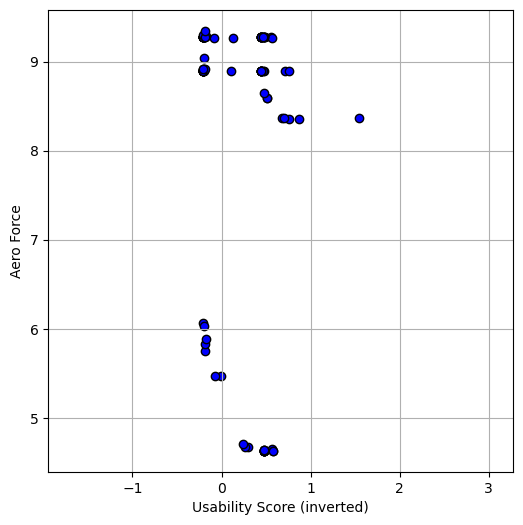

In [ ]:
points = res['y']
x = points[:, 0]
y = points[:, 1]

# Filter out negative y-values
mask = y >= 0
x = x[mask]
y = y[mask]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, c='blue', edgecolors='k')
plt.xlabel("Usability Score (inverted)")
plt.ylabel("Aero Force")
plt.grid(True)
plt.axis("equal") 
plt.show()

In [ ]:
print(res['y'])
print(res['y'].shape)


[[ 5.7076055e-01  4.6458716e+00]
 [ 7.0760936e-01  8.8921165e+00]
 [ 5.8059800e-01  4.6312418e+00]
 [ 4.8614955e-01  9.2741718e+00]
 [ 1.5406473e+00  8.3636589e+00]
 [-8.6211801e-02  9.2697229e+00]
 [ 1.0370529e-01  8.8947067e+00]
 [ 8.6979562e-01  8.3604746e+00]
 [ 5.5737340e-01  9.2715969e+00]
 [ 4.7569108e-01  9.2748470e+00]
 [ 5.7196403e-01  9.2695999e+00]
 [-2.1272779e-01 -2.4645598e+03]
 [ 1.2855315e-01  9.2688847e+00]
 [ 4.7358882e-01  8.8922291e+00]
 [ 4.4188440e-01  8.8922834e+00]
 [-1.9358647e-01  8.8957424e+00]
 [-1.8971574e-01  9.2719069e+00]
 [ 4.4123352e-01  9.2764025e+00]
 [ 5.7702780e-01  4.6328535e+00]
 [-2.1162832e-01  8.8940725e+00]
 [ 4.7197795e-01  9.2732458e+00]
 [ 7.5343329e-01  8.3571663e+00]
 [ 2.9522336e-01  4.6723199e+00]
 [ 4.4328117e-01  8.8928957e+00]
 [ 4.4327134e-01  8.8933115e+00]
 [-2.0637500e-01  8.8980322e+00]
 [ 4.7195148e-01  9.2732372e+00]
 [-2.0729661e-01  9.2750931e+00]
 [ 4.7497195e-01  4.6312647e+00]
 [ 4.4079977e-01  9.2783833e+00]
 [ 7.60049

In [ ]:
def test_general(args, condition, x0, prefs, solver, eval_fn, ref_point):
    problem = bicycle(condition=condition, n_obj=2, eval_fn=eval_fn)

    start_time = time.time()
    res = solver.solve(problem, x=x0, prefs=prefs, args=args, ref_point=ref_point)
    end_time = time.time()
    print(f"Time completed: {end_time - start_time:.2f} seconds")

    x0_np = x0.numpy() if isinstance(x0, torch.Tensor) else x0
    res_x_np = res['x'].numpy() if isinstance(res['x'], torch.Tensor) else res['x']
    assert x0_np.shape == res_x_np.shape, "The shapes of x0 and res['x'] must match"
    num_affected = 0
    for i in range(x0_np.shape[0]):  # Iterate over rows
        diff = np.count_nonzero(res_x_np[i] != x0_np[i])  
        num_affected += diff  

    print('Average Number of parameters affected:', num_affected/x0.shape[0])
    return res

In [ ]:
# aeroEV = [
#     AeroEvaluator(),
# ]
# usableEV = [
#     UsabilityEvaluator(),
# ]

# structuralEV = [
#     StructuralEvaluator(),
# ]

# evaluator_aero, _, _ = construct_tensor_evaluator(aeroEV, data.columns)
# evaluator_usable, _, _ = construct_tensor_evaluator(usableEV, data.columns)
# evaluator_structural, _, _ = construct_tensor_evaluator(structuralEV, data.columns)

# def eval_fn(x, condition): # All scores should be minimised
#     usable_score = 1 - evaluator_usable(x, condition)
#     aero_score = evaluator_aero(x, condition)
#     comb = torch.cat((usable_score, aero_score), dim=1)
#     return comb

# array([1.0 , 25.0 ])

In [ ]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
class BikeBenchProblem(Problem):
    def __init__(self, data_sample_df, conditioning):
        evaluator, requirement_names, requirement_types = construct_tensor_evaluator(StandardEvaluations, data_sample_df.columns)
        data_sample = data_sample_df.to_numpy()
        
        self.conditioning = conditioning

        self.evaluator=evaluator
        self.requirement_names=requirement_names
        isobjective = torch.tensor(requirement_types) == 1
        self.isobjective = isobjective

        n_var = data_sample.shape[1]
        n_obj = torch.sum(isobjective)
        n_ieq_constr = torch.sum(~isobjective)
        print(n_obj, n_ieq_constr)
        xl = np.min(data_sample, axis=0)
        xu = np.max(data_sample, axis=0)
        super().__init__(n_var=n_var, n_obj=n_obj, n_ieq_constr=n_ieq_constr, xl=xl, xu=xu)

    def evaluate_fn(self, X):
        X_tens = torch.tensor(X, dtype=torch.float32)
        eval_scores = self.evaluator(X_tens, self.conditioning)
        objective_scores = eval_scores[:, self.isobjective].detach().numpy()
        constraint_scores = eval_scores[:, ~self.isobjective].detach().numpy()
        return objective_scores, constraint_scores

    def _evaluate(self, x, out, *args, **kwargs):
        objective_scores, constraint_scores = self.evaluate_fn(x)
        out["F"] = objective_scores
        out["G"] = constraint_scores

In [ ]:
import torch
import numpy as np
from pymoo.optimize import minimize

class GradientBasedMOO:
    def __init__(self, problem, n_iters=100, lr=0.01, weights=None, verbose=True):
        self.problem = problem
        self.n_iters = n_iters
        self.lr = lr
        self.weights = weights
        self.verbose = verbose

    def optimize(self, x0):
        x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
        optimizer = torch.optim.SGD([x], lr=self.lr)

        history = []

        for it in range(self.n_iters):
            optimizer.zero_grad()

            # Evaluate the objectives and constraints
            scores = self.problem.evaluator(x.unsqueeze(0), self.problem.conditioning)[0]
            objectives = scores[self.problem.isobjective]
            constraints = scores[~self.problem.isobjective]

            # Check constraints (inequalities <= 0)
            constraint_violation = torch.clamp(constraints, min=0).sum()

            # Scalarization
            if self.weights is None:
                weights = torch.ones_like(objectives) / len(objectives)
            else:
                weights = torch.tensor(self.weights, dtype=torch.float32)

            scalarized_obj = torch.dot(weights, objectives) + 1000 * constraint_violation

            scalarized_obj.backward()
            optimizer.step()

            # Project back into bounds
            with torch.no_grad():
                x[:] = torch.max(x, torch.tensor(problem.xl, dtype=torch.float32))
                x[:] = torch.min(x, torch.tensor(problem.xu, dtype=torch.float32))

            history.append((it, objectives.detach().numpy()))

            if self.verbose and it % 10 == 0:
                print(f"Iter {it} | Objectives: {objectives.detach().numpy()} | Constraint Violation: {constraint_violation.item()}")

        return x.detach().numpy(), history


In [ ]:
problem = BikeBenchProblem(data, condition)

x0 = (problem.xl + problem.xu) / 2

# Use equal weights for all objectives
optimizer = GradientBasedMOO(problem, n_iters=100, lr=0.1, weights=None)
best_x, hist = optimizer.optimize(x0)
print("Best design found:", best_x)

tensor(9) tensor(13)
Iter 0 | Objectives: [  0.40399897  20.09041      0.          72.24051    113.654465
   0.          97.73312    117.01261     61.42987   ] | Constraint Violation: 3.0
Iter 10 | Objectives: [  0.40399438  20.196644     0.          71.9513     113.347824
   0.          97.32826    116.62717     61.127842  ] | Constraint Violation: 3.0
Iter 20 | Objectives: [  0.40398982  20.300735     0.          71.66258    113.04147
   0.          96.92349    116.24185     60.825893  ] | Constraint Violation: 3.0
Iter 30 | Objectives: [  0.40398526  20.40424      0.          71.375656   112.73686
   0.          96.85128    116.1835      60.763954  ] | Constraint Violation: 3.0
Iter 40 | Objectives: [  0.40398055  20.506947     0.          71.09033    112.43379
   0.          96.82378    116.15694     60.734997  ] | Constraint Violation: 3.0
Iter 50 | Objectives: [  0.40397573  20.607914     0.          70.80577    112.13139
   0.          96.796234   116.13037     60.70603   ] | Co

In [ ]:
init_obj, init_const = problem.evaluate_fn(torch.tensor(x0, dtype=torch.float32, requires_grad=False).unsqueeze(0))
final_obj, final_const = problem.evaluate_fn(torch.tensor(best_x).unsqueeze(0))

print("Initial design:", x0)
print("Final design:", best_x)
print("Initial scores (Objectives):", initial[0])
print("Initial scores (Constraints):", initial[1])
print("Final scores (Objectives):", final[0])
print("Final scores (Constraints):", final[1])

Initial design: [ 1.00000000e+03 -2.27000000e+02  7.86023727e+02  5.45000000e+01
  6.48500000e+02  1.95000000e+01  4.74200000e+02  6.25000000e+01
  1.10852435e+03  3.75000000e+02  4.50000000e+01  7.13500000e+01
  6.66250000e+01  5.50000000e+01  3.57500000e+01  4.44400000e+03
  3.90000000e+01  1.60000000e+02  2.43200000e+02 -2.24150000e+02
  3.61000000e+02  4.05000000e+02  3.05000000e+01  2.95000000e+01
  5.00000000e-01  5.00000000e-01  1.82500000e+02  2.00000000e+00
  9.00000000e-01  1.10000000e+00  9.00000000e-01  6.00000000e-01
  5.00000000e-01  7.00000000e-01  9.36000000e+02  1.36500000e+02
  9.91000000e+02  9.99000000e+01  5.00000000e-01  3.54000000e+03
  4.25000000e+01  4.21000000e+02  7.00000000e+01  5.00000000e-01
  5.00000000e-01  5.50000000e+00  1.00000000e+00  5.00000000e-01
  1.27500000e+02  1.27500000e+02  1.27500000e+02  5.00000000e+00
  5.00000000e+00  2.52500000e+02  7.25000000e+01  4.80000000e+02
  8.51350000e+02  6.70000000e+01  3.50000000e+02  5.00000000e-01
  5.00000

In [ ]:
def sample_simplex_weights(n_obj, n_samples):
    """
    Sample weight vectors on the unit simplex.
    For now, use linear sweep on the diagonal of the simplex.
    """
    weights = []
    for alpha in np.linspace(0, 1, n_samples):
        w = np.ones(n_obj) * (1 - alpha) / (n_obj - 1)
        w[0] = alpha
        weights.append(w)
    return np.array(weights)

def gradient_based_pareto_front(problem, n_weights=20, n_iters=100, lr=0.01):
    pareto_solutions = []
    pareto_objectives = []

    n_obj = problem.isobjective.sum().item()  # Get number of objectives

    weight_vectors = sample_simplex_weights(n_obj, n_weights)

    for weights_np in weight_vectors:
        weights = torch.tensor(weights_np, dtype=torch.float32)

        # Start from middle of bounds
        x0 = (problem.xl + problem.xu) / 2
        x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
        optimizer = torch.optim.Adam([x], lr=lr)

        for _ in range(n_iters):
            optimizer.zero_grad()
            scores = problem.evaluator(x.unsqueeze(0), problem.conditioning)[0]
            objectives = scores[problem.isobjective]
            constraints = scores[~problem.isobjective]
            constraint_violation = torch.clamp(constraints, min=0).sum()

            # Scalarized loss
            scalarized = torch.dot(weights, objectives) + 1000 * constraint_violation
            scalarized.backward()
            optimizer.step()

            with torch.no_grad():
                x[:] = torch.max(x, torch.tensor(problem.xl, dtype=torch.float32))
                x[:] = torch.min(x, torch.tensor(problem.xu, dtype=torch.float32))

        # Save if feasible
        with torch.no_grad():
            scores = problem.evaluator(x.unsqueeze(0), problem.conditioning)[0]
            constraints = scores[~problem.isobjective]
            if (constraints <= 0).all():
                pareto_solutions.append(x.detach().numpy())
                pareto_objectives.append(scores[problem.isobjective].detach().numpy())

    pareto_solutions = np.array(pareto_solutions)
    pareto_objectives = np.array(pareto_objectives)
    return pareto_solutions, pareto_objectives


In [ ]:
pareto_X, pareto_F = gradient_based_pareto_front(problem, n_weights=5, n_iters=10, lr=0.01)

# Visualize
# import matplotlib.pyplot as plt

# plt.plot(pareto_F[:, 0], pareto_F[:, 1], 'o-', label="Pareto Front (Gradient)")
# plt.xlabel("Objective 1")
# plt.ylabel("Objective 2")
# plt.grid(True)
# plt.legend()
# plt.title("Gradient-based Pareto Front")
# plt.show()


In [ ]:
pareto_X

array([], dtype=float64)

In [ ]:
result_tens = torch.tensor(pareto_X, dtype=torch.float32).unsqueeze(0)

In [ ]:
main_scorer = construct_scorer(MainScores, StandardEvaluations, data.columns)
detailed_scorer = construct_scorer(DetailedScores, StandardEvaluations, data.columns)

In [ ]:
main_scorer(result_tens, condition)

Hypervolume                     0.000000
Constraint Satisfaction Rate    0.846154
Maximum Mean Discrepancy        1.576790
dtype: float64

In [ ]:
detailed_scorer(result_tens, condition)


Min Objective Score: Usability Score - 0 to 1                                                                 0.791411
Min Objective Score: Drag Force                                                                              27.933560
Min Objective Score: Knee Angle Error                                                                       186.338130
Min Objective Score: Hip Angle Error                                                                        822.850400
Min Objective Score: Arm Angle Error                                                                        861.650940
Min Objective Score: Mass                                                                                    22.190498
Min Objective Score: Planar Compliance                                                                      180.347920
Min Objective Score: Transverse Compliance                                                                  265.026400
Min Objective Score: Eccentric Compliance       